Checking files:

In [1]:
import numpy  as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyc-taxi-trip-duration/sample_submission.csv
/kaggle/input/nyc-taxi-trip-duration/test.csv
/kaggle/input/nyc-taxi-trip-duration/train.csv
/kaggle/input/nyc-taxi-trip-duration/test/test.csv
/kaggle/input/nyc-taxi-trip-duration/sample_submission/sample_submission.csv
/kaggle/input/nyc-taxi-trip-duration/train/train.csv


Summoning some libs:

In [70]:
import datetime
import warnings
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns
from pandas.plotting import scatter_matrix

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute          import SimpleImputer
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler

from sklearn.cluster      import KMeans, DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.tree         import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_log_error


from IPython.display import display

#

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [13, 7]
np.random.seed(1642)

Defining some functions:

In [3]:
# constants and functions

def var_cleaner(s):
    """
    ('var1, var2, ..., varN') -> None
    """
    trash = list()
    miss  = list()
    for v in s.replace(' ', '').split(','):
        if v in globals():
            del globals()[v]
            trash.append(v)
        else:
            miss.append(v)
    print('- DELETED:     {}'.format( ', '.join(trash) ))
    print('- NOT DEFINED: {}'.format( ', '.join(miss) ))

from math import sin, cos, sqrt, atan2, radians
def lat_lon_converter(lat1, lon1, lat2, lon2, unit):
    """
    ref: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    """
    try:
        R = 6373.0
        dlon = radians(lon2) - radians(lon1)
        dlat = radians(lat2) - radians(lat1)
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c

        if unit == 'm':
            return distance * 10e3
        elif unit == 'km':
            return distance
    except ValueError:
        return np.nan

    
def dbscan_predict(model, X):
    """
    ref: https://stackoverflow.com/questions/27822752/scikit-learn-predicting-new-points-with-dbscan
    """
    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]   # NumPy broadcasting
        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance
        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new


import scipy as sp
def dbscan_predict2(dbscan_model, X_new, metric=sp.spatial.distance.euclidean):
    """
    ref: https://stackoverflow.com/questions/27822752/scikit-learn-predicting-new-points-with-dbscan
    """
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.components_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                # Assign label of x_core to x_new
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break

    return y_new

# Exploring

In [4]:
df_train = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.csv')
df_test  = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/test.csv')

print('train: ', df_train.shape)
print('test:  ', df_test.shape)

display( df_train.head() )
display( df_test.head() )

train:  (1458644, 11)
test:   (625134, 9)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [5]:
_TARGET      = 'trip_duration'
_NON_FEATURE = set(df_train.columns) - set(df_test.columns)
_FEATURES    = set(df_train.columns).intersection(set(df_test.columns)) - set(['id'])
display(_FEATURES)

{'dropoff_latitude',
 'dropoff_longitude',
 'passenger_count',
 'pickup_datetime',
 'pickup_latitude',
 'pickup_longitude',
 'store_and_fwd_flag',
 'vendor_id'}

In [6]:
train = df_train[_FEATURES]

## Overview

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 8 columns):
dropoff_longitude     1458644 non-null float64
pickup_longitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
passenger_count       1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_latitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
vendor_id             1458644 non-null int64
dtypes: float64(4), int64(2), object(2)
memory usage: 89.0+ MB


In [8]:
train.describe().apply( lambda s: s.apply( lambda x: format(x, '.3f') ) )

,dropoff_longitude,pickup_longitude,passenger_count,dropoff_latitude,pickup_latitude,vendor_id
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,-73.973,-73.973,1.665,40.752,40.751,1.535
std,0.071,0.071,1.314,0.036,0.033,0.499
min,-121.933,-121.933,0.000,32.181,34.360,1.000
25%,-73.991,-73.992,1.000,40.736,40.737,1.000
50%,-73.980,-73.982,1.000,40.755,40.754,2.000
75%,-73.963,-73.967,2.000,40.770,40.768,2.000
max,-61.336,-61.336,9.000,43.921,51.881,2.000


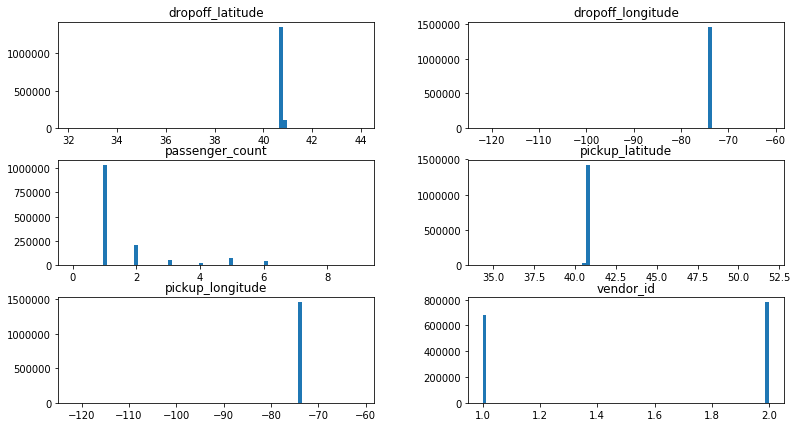

In [9]:
# scatter_matrix(train[train.dtypes[train.dtypes != object].index].sample(frac=0.005), diagonal='kde'); it doesnt bring any insight
train[train.dtypes[train.dtypes != object].index].hist(bins=75, grid='off');

## Dealing with outliers

In [10]:
_FILTER_OBJECT = train.dtypes[train.dtypes != object].index

In [11]:
for _col in _FILTER_OBJECT:
    #train['{}_quantile'.format(_col)] = pd.qcut(train[_col], 10, labels=False, duplicates='drop')
    _std  = train[_col].std()
    _mean = train[_col].mean()
    train['{}_outlier'.format(_col)] = train[_col].apply( lambda x: True if ( abs(x) > abs(_mean + 1.5*_std) ) else False)

In [12]:
# train[train['trip_duration_outlier'] == False].hist(column = 'trip_duration', 
#                                                     by     = 'passenger_count',
#                                                     bins   = 50, grid='off', alpha = 0.5)
# plt.title('Trip Duration Distributions per Passenger Count')
# plt.legend();

<s>Binning trip duration:</s>

In [13]:
# _TRIP_BINS = [0.0, 300.0, 600.0, np.inf]
# train['trip_duration_cat'] = pd.cut( train['trip_duration'],
#                                      bins   = _TRIP_BINS,
#                                      labels = [i for i in range(len(_TRIP_BINS)-1)])
# train['trip_duration_cat'].value_counts(normalize=True).sort_index()

## Geographical data

In [14]:
_FILTER = (train['dropoff_latitude_outlier'] == False) & (train['dropoff_longitude_outlier'] == False)
# display( train['dropoff_longitude_outlier'].value_counts() )
# display( train['dropoff_latitude_outlier'].value_counts() )
# display( (_FILTER).value_counts() )

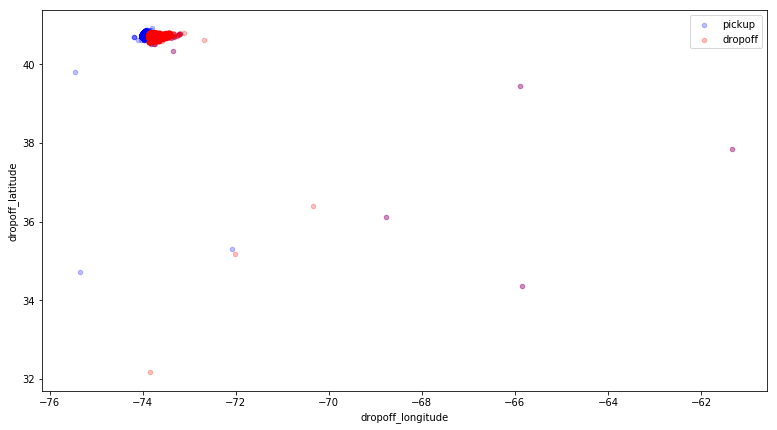

In [15]:
_p = train[_FILTER].plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.25, color='b', label='pickup')
train[_FILTER].plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', alpha=0.25, color='r', label='dropoff', ax=_p)
plt.legend();

- - -

# Model

In [79]:
var_cleaner('df_train,  df_test, _TARGET, _NON_FEATURE, _FEATURES, train')

#

df_train = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.csv')
df_test  = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/test.csv')

print('train: ', df_train.shape)
print('test:  ', df_test.shape)

_TARGET      = 'trip_duration'
_NON_FEATURE = set(df_train.columns) - set(df_test.columns)
_FEATURES    = set(df_train.columns).intersection(set(df_test.columns)) - set(['id', 'vendor_id'])
train = df_train[_FEATURES]
test  = df_test[_FEATURES]

display(_FEATURES)

- DELETED:     df_train, df_test, _TARGET, _NON_FEATURE, _FEATURES, train
- NOT DEFINED: 
train:  (1458644, 11)
test:   (625134, 9)


{'dropoff_latitude',
 'dropoff_longitude',
 'passenger_count',
 'pickup_datetime',
 'pickup_latitude',
 'pickup_longitude',
 'store_and_fwd_flag'}

## Simple Feature Engineering

### Clustering

In [17]:
_sample = train[_FILTER].sample(3000, random_state=159)[['pickup_longitude', 'pickup_latitude']]

#### Kmeans

array([[-73.97455237,  40.7635236 ],
       [-73.78526444,  40.6493026 ],
       [-73.87107649,  40.76201433],
       [-73.99441015,  40.72700273],
       [-73.4761076 ,  40.73979664]])

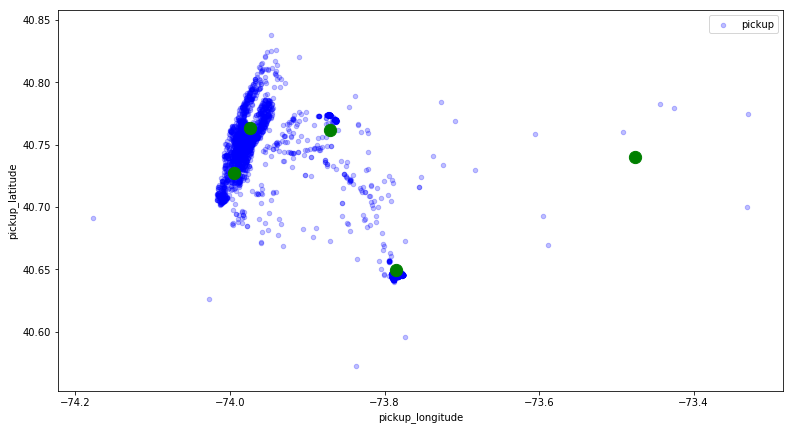

In [18]:
kmeans = KMeans(n_clusters=5, random_state=51).fit(_sample)

display(kmeans.cluster_centers_)
_p = _sample.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.25, color='b', label='pickup')
_p.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1], marker='o', color='g', s=150);

#### DBSCAN

In [19]:
dbscan = DBSCAN(eps=0.01, min_samples=15).fit(_sample)

core_samples_mask = np.zeros_like( dbscan.labels_, dtype=bool )
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_    = list(labels).count(-1)

print('Estimated number of clusters:     %d'    % n_clusters_)
print('Estimated number of noise points: %d'    % n_noise_)
# print("Homogeneity:                      %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness:                     %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure:                        %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index:              %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information:      %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels, average_method='arithmetic'))
print("Silhouette Coefficient:           %0.3f" % metrics.silhouette_score(_sample[['pickup_longitude', 'pickup_latitude']], labels))

#

unique_labels = set(labels)
colors        = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

Estimated number of clusters:     7
Estimated number of noise points: 178
Silhouette Coefficient:           0.397


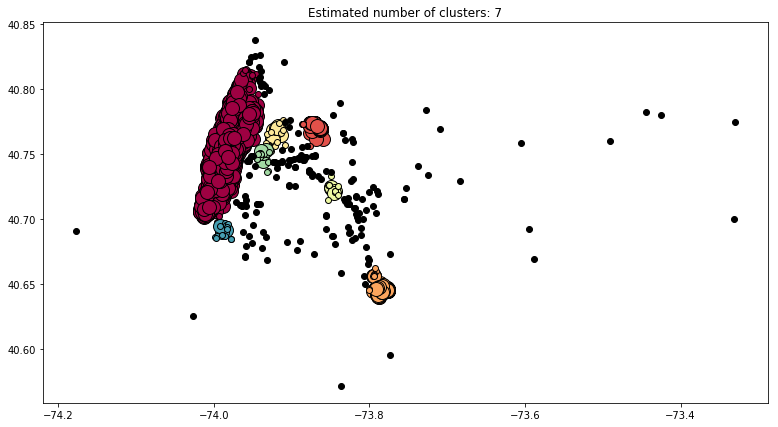

In [20]:
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1] # Black used for noise.

    class_member_mask = (labels == k)

    xy = _sample[class_member_mask & core_samples_mask].as_matrix()
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = _sample[class_member_mask & ~core_samples_mask].as_matrix()
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Predicting all observations:

In [21]:
train['db_predict']     = dbscan_predict(dbscan, train[['pickup_longitude', 'pickup_latitude']].as_matrix())
train['kmeans_predict'] = kmeans.predict(train[['pickup_longitude', 'pickup_latitude']])

In [22]:
display( train['db_predict'].value_counts().sort_index() )
display( train['kmeans_predict'].value_counts().sort_index() )

-1      38437
 0    1334849
 1      37124
 2      31775
 3       4349
 4        253
 5       3945
 6       7912
Name: db_predict, dtype: int64

0    864143
1     33179
2     46142
3    515083
4        97
Name: kmeans_predict, dtype: int64

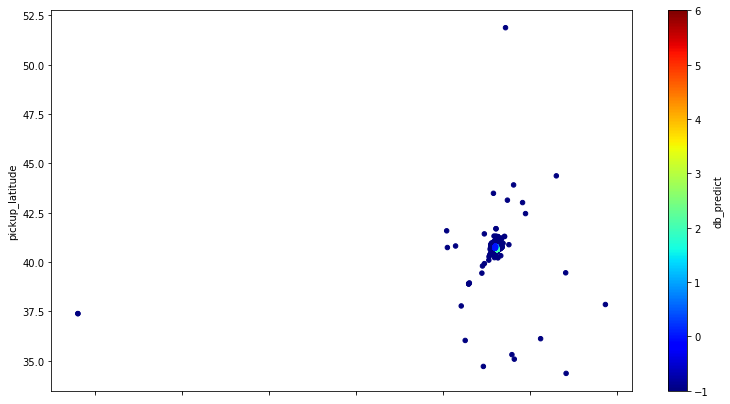

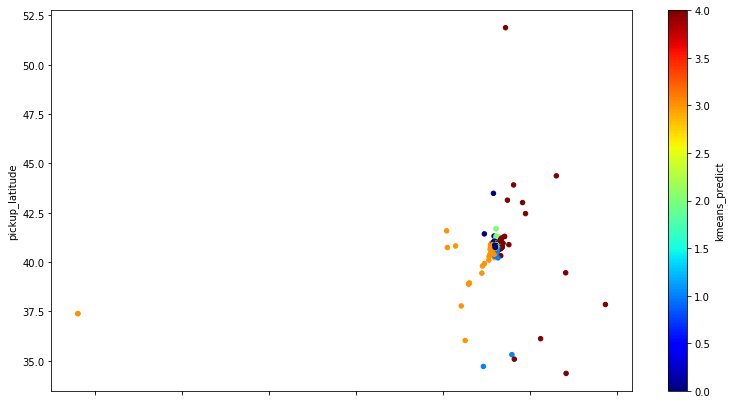

In [23]:
train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', c='db_predict', cmap=plt.get_cmap('jet'));
train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', c='kmeans_predict', cmap=plt.get_cmap('jet'));

### Additional feature combination

In [24]:
train['lon_lat_manhattan']    = abs(train['dropoff_longitude']-train['pickup_longitude']) + abs(train['dropoff_latitude']-train['pickup_latitude'])
train['dist_manhattan_meter'] = train.apply( lambda x: lat_lon_converter(x['pickup_latitude'], 
                                                                         x['pickup_longitude'],
                                                                         x['dropoff_latitude'], 
                                                                         x['dropoff_longitude'],
                                                                         'm'), axis=1 )

In [25]:
#train['pickup_dt']   = train['pickup_datetime'].apply( lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
#train['dropoff_dt']  = train['dropoff_datetime'].apply( lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train['pickup_dt']    = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S', errors='ignore')
# train['dropoff_dt'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S', errors='ignore')
# train['delta_time'] = (train['dropoff_dt'] - train['pickup_dt']).dt.total_seconds()

# train[['pickup_dt', 'pickup_datetime']]

In [26]:
train['pick_minute']     = train['pickup_dt'].dt.minute
train['pick_hour']       = train['pickup_dt'].dt.hour
train['pick_day']        = train['pickup_dt'].dt.day
train['pick_month']      = train['pickup_dt'].dt.month
train['pick_year']       = train['pickup_dt'].dt.year
train['pick_quarter']    = train['pickup_dt'].dt.quarter
train['pick_weekofyear'] = train['pickup_dt'].dt.weekofyear

In [27]:
# train['avg_speed']           = train['dist_manhattan_meter'] / train['delta_time']
# train['dist_per_passenger']  = train['dist_manhattan_meter'] / train['passenger_count']
# train['speed_per_passenger'] = train['avg_speed'] / train['passenger_count']

## Data Cleaning

In [28]:
# _FILTER_NUM = set(train.dtypes[(train.dtypes != np.dtype('object')) & (train.dtypes != np.dtype('<M8[ns]'))].index.to_list())
_FILTER_INT    = set(train.dtypes[(train.dtypes == np.dtype('int64'))].index.to_list())
_FILTER_FLOAT  = set(train.dtypes[(train.dtypes == np.dtype('float64'))].index.to_list())
_FILTER_CAT    = set(train.dtypes[(train.dtypes == np.dtype('object'))].index.to_list())
_FILTER_DT     = set(train.dtypes[(train.dtypes == np.dtype('<M8[ns]'))].index.to_list())

train[ _FILTER_INT.union(_FILTER_FLOAT).union(_FILTER_CAT).union(_FILTER_DT) ].describe().apply( lambda s: s.apply( lambda x: format(x, '.3f') ) )

,dropoff_longitude,passenger_count,db_predict,pick_quarter,lon_lat_manhattan,dist_manhattan_meter,pick_month,pick_year,pick_minute,pickup_latitude,pick_weekofyear,pickup_longitude,dropoff_latitude,pick_hour,pick_day
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458641.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,-73.973,1.665,0.098,1.504,0.046,39313.599,3.517,2016.000,29.590,40.751,13.840,-73.973,40.752,13.606,15.504
std,0.071,1.314,0.649,0.500,0.060,49359.235,1.681,0.000,17.325,0.033,8.565,0.071,0.036,6.400,8.703
min,-121.933,0.000,-1.000,1.000,0.000,0.000,1.000,2016.000,0.000,34.360,1.000,-121.933,32.181,0.000,1.000
25%,-73.991,1.000,0.000,1.000,0.016,13969.256,2.000,2016.000,15.000,40.737,7.000,-73.992,40.736,9.000,8.000
50%,-73.980,1.000,0.000,2.000,0.027,23556.726,4.000,2016.000,30.000,40.754,13.000,-73.982,40.755,14.000,15.000
75%,-73.963,2.000,0.000,2.000,0.050,42646.922,5.000,2016.000,45.000,40.768,20.000,-73.967,40.770,19.000,23.000
max,-61.336,9.000,6.000,2.000,12.908,12383530.284,6.000,2016.000,59.000,51.881,53.000,-61.336,43.921,23.000,31.000


In [29]:
# train['dist_per_passenger']  = train['dist_per_passenger'].replace([np.inf, -np.inf], np.nan)
# train['speed_per_passenger'] = train['speed_per_passenger'].replace([np.inf, -np.inf], np.nan)

In [30]:
display(_FILTER_INT)
display(_FILTER_FLOAT)
display(_FILTER_CAT)
display(_FILTER_DT)

{'db_predict',
 'passenger_count',
 'pick_day',
 'pick_hour',
 'pick_minute',
 'pick_month',
 'pick_quarter',
 'pick_weekofyear',
 'pick_year'}

{'dist_manhattan_meter',
 'dropoff_latitude',
 'dropoff_longitude',
 'lon_lat_manhattan',
 'pickup_latitude',
 'pickup_longitude'}

{'pickup_datetime', 'store_and_fwd_flag'}

{'pickup_dt'}

In [31]:
_FILTER_CAT = _FILTER_CAT - {'pickup_datetime'}

In [32]:
# imputer = SimpleImputer(strategy='median')
# imputer.fit(train[(_FILTER_OBJECT)])
# X = imputer.transform(train[_FILTER_OBJECT])
# train_tr = pd.DataFrame(X, columns=train[(_FILTER_OBJECT)].columns)
int_pipeline = Pipeline([ ('imputer', SimpleImputer(strategy="constant", fill_value=-1))])

float_pipeline = Pipeline([ ('imputer', SimpleImputer(strategy="median")),
                          ('std_scaler', StandardScaler())
                        ])

In [36]:
full_pipeline = ColumnTransformer([
                 ('int',   int_pipeline,    list(_FILTER_INT)),
                 ('float', float_pipeline,  list(_FILTER_FLOAT)),
                 ('cat',   OneHotEncoder(), list(_FILTER_CAT))
                 ])

d

## Train & Test

In [53]:
train_y['trip_duration'] = train_y['trip_duration'].mask(train_y['trip_duration'].lt(0), 0)
_TRIP_BINS = [0.0, 300.0, 600.0, np.inf]
train_y['trip_duration_cat'] = pd.cut( train_y['trip_duration'],
                                     bins   = _TRIP_BINS,
                                     labels = [i for i in range(len(_TRIP_BINS)-1)])
train_y['trip_duration_cat'].value_counts(normalize=True).sort_index()

0    0.152139
1    0.295478
2    0.552384
Name: trip_duration_cat, dtype: float64

In [54]:
X_train, X_holdout, y_train, y_holdout = train_test_split(train_prepared, train_y, 
                                          test_size    = 0.2, 
                                          random_state = 13,
                                          stratify     = train_y['trip_duration_cat'])

display( y_train['trip_duration_cat'].value_counts(normalize=True).sort_index() )
display( y_holdout['trip_duration_cat'].value_counts(normalize=True).sort_index() )

y_train = y_train.drop(columns=['trip_duration_cat'])
y_holdout = y_holdout.drop(columns=['trip_duration_cat'])

0    0.152139
1    0.295477
2    0.552384
Name: trip_duration_cat, dtype: float64

0    0.152138
1    0.295480
2    0.552383
Name: trip_duration_cat, dtype: float64

Fit:

In [77]:
# linreg = LinearRegression(fit_intercept=False)
# linreg.fit(X_train, y_train)
treereg = DecisionTreeRegressor(random_state=40, max_depth=7).fit(X_train, y_train)

Predict:

In [78]:
y_pred = treereg.predict(X_holdout)
mean_squared_log_error( y_holdout, y_pred )

0.3329976614407157

# Submission

In [81]:
test['db_predict']     = dbscan_predict(dbscan, test[['pickup_longitude', 'pickup_latitude']].as_matrix())
test['kmeans_predict'] = kmeans.predict(test[['pickup_longitude', 'pickup_latitude']])

test['lon_lat_manhattan']    = abs(test['dropoff_longitude']-test['pickup_longitude']) + abs(test['dropoff_latitude']-test['pickup_latitude'])
test['dist_manhattan_meter'] = test.apply( lambda x: lat_lon_converter(x['pickup_latitude'], 
                                                                         x['pickup_longitude'],
                                                                         x['dropoff_latitude'], 
                                                                         x['dropoff_longitude'],
                                                                         'm'), axis=1 )
test['pickup_dt']    = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S', errors='ignore')
test['pick_minute']     = test['pickup_dt'].dt.minute
test['pick_hour']       = test['pickup_dt'].dt.hour
test['pick_day']        = test['pickup_dt'].dt.day
test['pick_month']      = test['pickup_dt'].dt.month
test['pick_year']       = test['pickup_dt'].dt.year
test['pick_quarter']    = test['pickup_dt'].dt.quarter
test['pick_weekofyear'] = test['pickup_dt'].dt.weekofyear

test_x = test[ _FILTER_INT.union(_FILTER_FLOAT).union(_FILTER_CAT) ]
test_prepared = full_pipeline.fit_transform(test_x)

In [87]:
pred = treereg.predict(test_prepared)

df_test['trip_duration'] = pred.astype(int)
out = df_test[['id', 'trip_duration']]
out.to_csv('pred_treereg.csv',index=False)

- - -